In [14]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
import random
import pickle
from sklearn import preprocessing
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Train or load the doc2vec model --- #
	flag_train_doc2vec = False

	if flag_train_doc2vec:

		# --- Prepare training data of doc2vec --- #
		doc2vec_corpus_en = []
		doc2vec_corpus_jp = []
		for i, doc in enumerate(pairs_correct):
			doc2vec_corpus_en.append(TaggedDocument(words=doc[0].split(), tags=[i]))
			doc2vec_corpus_jp.append(TaggedDocument(words=doc[1].split(), tags=[i]))

		# --- Train the doc2vec model --- #
		doc2vec_model_en = doc2vec.Doc2Vec(doc2vec_corpus_en, size=200, window=8, min_count=1, workers=14)
		doc2vec_model_jp = doc2vec.Doc2Vec(doc2vec_corpus_jp, size=200, window=8, min_count=1, workers=14)

		# --- Save the doc2vec model --- #
		doc2vec_model_jp.save("./data/doc2vec_model_jp")
		doc2vec_model_en.save("./data/doc2vec_model_en")

	else:
		# --- Load the saved doc2vec model --- #
		doc2vec_model_en = doc2vec.Doc2Vec.load("./data/doc2vec_model_jp")
		doc2vec_model_jp = doc2vec.Doc2Vec.load("./data/doc2vec_model_en")


	# --- Evaluation 1: Using the cross-lingual projection directly --- #

	# --- Evaluation 2: Using SVM training --- #

	features_en = list(doc2vec_model_en.docvecs)[:5000]
	features_jp = list(doc2vec_model_jp.docvecs)[:5000]
	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle(features_en_wrong)
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong = np.split(X, [2000, 3000, 5000])
	y_train1, y_test, y_train2, y_train3_wrong = np.split(y, [2000, 3000, 5000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64
C value = 0


In [12]:
X

array([[ 5.1,  3.5],
       [ 4.9,  3. ],
       [ 4.7,  3.2],
       [ 4.6,  3.1],
       [ 5. ,  3.6],
       [ 5.4,  3.9],
       [ 4.6,  3.4],
       [ 5. ,  3.4],
       [ 4.4,  2.9],
       [ 4.9,  3.1],
       [ 5.4,  3.7],
       [ 4.8,  3.4],
       [ 4.8,  3. ],
       [ 4.3,  3. ],
       [ 5.8,  4. ],
       [ 5.7,  4.4],
       [ 5.4,  3.9],
       [ 5.1,  3.5],
       [ 5.7,  3.8],
       [ 5.1,  3.8],
       [ 5.4,  3.4],
       [ 5.1,  3.7],
       [ 4.6,  3.6],
       [ 5.1,  3.3],
       [ 4.8,  3.4],
       [ 5. ,  3. ],
       [ 5. ,  3.4],
       [ 5.2,  3.5],
       [ 5.2,  3.4],
       [ 4.7,  3.2],
       [ 4.8,  3.1],
       [ 5.4,  3.4],
       [ 5.2,  4.1],
       [ 5.5,  4.2],
       [ 4.9,  3.1],
       [ 5. ,  3.2],
       [ 5.5,  3.5],
       [ 4.9,  3.1],
       [ 4.4,  3. ],
       [ 5.1,  3.4],
       [ 5. ,  3.5],
       [ 4.5,  2.3],
       [ 4.4,  3.2],
       [ 5. ,  3.5],
       [ 5.1,  3.8],
       [ 4.8,  3. ],
       [ 5.1,  3.8],
       [ 4.6,

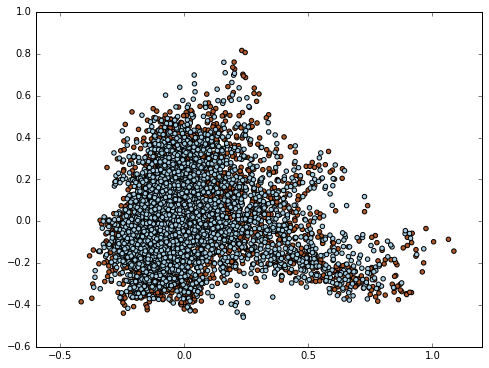

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features.
# Y = iris.target

X = X_train
Y = y_train

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# # Plot the training points
# plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
# ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_train)
ax.scatter(X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])


plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Paired)

plt.show()

In [22]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec
from sklearn import preprocessing
import random
import pickle
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def average_docment(document_embedding):
	return np.average(document_embedding, axis=0)

def sum_docment(document_embedding):
	return np.sum(document_embedding, axis=0)

def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Apply the word2vec model to the data sets --- #

	model_name_en = "./data/model-en/W2Vmodle.bin"
	model_name_jp = "./data/model-jp/W2Vmodle.bin"

	df_pairs_sample = df_pairs.iloc[0:5000]

	df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
	df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


	# Feature 1: TF-IDF + Average word2vec

	# --- Find tf-idf * word2vec features --- #

    #  For English text:
	texts_en = [doc.split() for doc in list(df_pairs_sample["en_article"])]
	dictionary_en = corpora.Dictionary(texts_en)
	corpus_en = [dictionary_en.doc2bow(text) for text in texts_en]
	tfidf_en = models.TfidfModel(corpus_en)

	#  For Japanese text:
	texts_jp = [doc.split() for doc in list(df_pairs_sample["jp_article"])]
	dictionary_jp = corpora.Dictionary(texts_jp)
	corpus_jp = [dictionary_jp.doc2bow(text) for text in texts_jp]
	tfidf_jp = models.TfidfModel(corpus_jp)

	features_en = doc2feature(corpus_en, tfidf_en, dictionary_en, model_en)
	features_jp = doc2feature(corpus_jp, tfidf_jp, dictionary_jp, model_jp)

	# --- When do not apply the tfidf re-weighting --- #
	flag_NO_tfidf = True
	if flag_NO_tfidf:

		df_pairs_sample["sum_vector_en"] = df_pairs_sample['word2vec_en'].apply(sum_docment)
		df_pairs_sample["sum_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(sum_docment)
		df_pairs_sample["average_vector_en"] = df_pairs_sample['word2vec_en'].apply(average_docment)
		df_pairs_sample["average_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(average_docment)

		features_en = list(df_pairs_sample["average_vector_en"])
		features_jp = list(df_pairs_sample["average_vector_jp"])


	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle((features_en_wrong))
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong = np.split(X, [2000, 3000, 5000])
	y_train1, y_test, y_train2, y_train3_wrong = np.split(y, [2000, 3000, 5000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1000
2000
3000
4000
0
1000
2000
3000
4000


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C value = 1


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


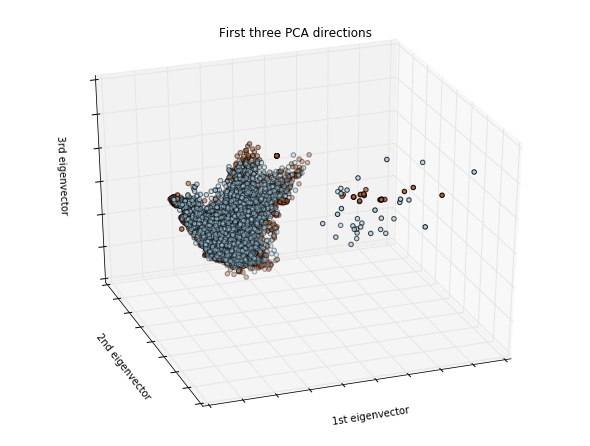

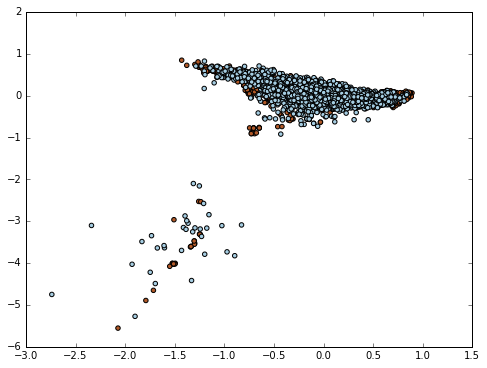

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features.
# Y = iris.target

X = X_train
Y = y_train

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

X_reduced = PCA(n_components=3).fit_transform(X_train)

# # Plot the training points
# plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Paired)

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [27]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec
from sklearn import preprocessing
import random
import pickle
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def average_docment(document_embedding):
	return np.average(document_embedding, axis=0)

def sum_docment(document_embedding):
	return np.sum(document_embedding, axis=0)

def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Apply the word2vec model to the data sets --- #

	model_name_en = "./data/model-en/W2Vmodle.bin"
	model_name_jp = "./data/model-jp/W2Vmodle.bin"

	df_pairs_sample = df_pairs.iloc[0:5000]

	df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
	df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


	# Feature 1: TF-IDF + Average word2vec

	# --- Find tf-idf * word2vec features --- #

    #  For English text:
	texts_en = [doc.split() for doc in list(df_pairs_sample["en_article"])]
	dictionary_en = corpora.Dictionary(texts_en)
	corpus_en = [dictionary_en.doc2bow(text) for text in texts_en]
	tfidf_en = models.TfidfModel(corpus_en)

	#  For Japanese text:
	texts_jp = [doc.split() for doc in list(df_pairs_sample["jp_article"])]
	dictionary_jp = corpora.Dictionary(texts_jp)
	corpus_jp = [dictionary_jp.doc2bow(text) for text in texts_jp]
	tfidf_jp = models.TfidfModel(corpus_jp)

	features_en = doc2feature(corpus_en, tfidf_en, dictionary_en, model_en)
	features_jp = doc2feature(corpus_jp, tfidf_jp, dictionary_jp, model_jp)

	# --- When do not apply the tfidf re-weighting --- #
	flag_NO_tfidf = False
	if flag_NO_tfidf:

		df_pairs_sample["sum_vector_en"] = df_pairs_sample['word2vec_en'].apply(sum_docment)
		df_pairs_sample["sum_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(sum_docment)
		df_pairs_sample["average_vector_en"] = df_pairs_sample['word2vec_en'].apply(average_docment)
		df_pairs_sample["average_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(average_docment)

		features_en = list(df_pairs_sample["average_vector_en"])
		features_jp = list(df_pairs_sample["average_vector_jp"])


	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle((features_en_wrong))
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong = np.split(X, [2000, 3000, 5000])
	y_train1, y_test, y_train2, y_train3_wrong = np.split(y, [2000, 3000, 5000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

	# --- SVM Training --- #

	clf = svm.SVC(kernel="rbf", gamma=0.001, C=100, probability=True)

	# 在使用
	standerlization = 2
	if standerlization == 1:
		scaler = preprocessing.StandardScaler().fit(X_train)
		X_scaled = scaler.transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)

	if standerlization == 2:
		min_max_scaler = preprocessing.MinMaxScaler()
		X_scaled = min_max_scaler.fit_transform(X_train)
		X_test_scaled = min_max_scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)
	else:
		clf.fit(X_train, y_train)
		# clf.score(X_train, y_train)
		# clf.score(X_test, y_test)
		y_test_predict = clf.predict(X_test)
		y_train_predict = clf.predict(X_train)



	print "classification report of TRAINING data:"
	print(classification_report(y_train, y_train_predict))

	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict))

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 2
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.67      0.96      0.79      5000
        1.0       0.89      0.41      0.56      4000

avg / total       0.77      0.72      0.69      9000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.16      0.28      1000

avg / total       1.00      0.16      0.28      1000



/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
	# 在使用
	standerlization = 0
	if standerlization == 1:
		scaler = preprocessing.StandardScaler().fit(X_train)
		X_scaled = scaler.transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)

	if standerlization == 2:
		min_max_scaler = preprocessing.MinMaxScaler()
		X_scaled = min_max_scaler.fit_transform(X_train)
		X_test_scaled = min_max_scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)
	else:
		clf.fit(X_train, y_train)
		# clf.score(X_train, y_train)
		# clf.score(X_test, y_test)
		y_test_predict = clf.predict(X_test)
		y_train_predict = clf.predict(X_train)



	print "classification report of TRAINING data:"
	print(classification_report(y_train, y_train_predict))

	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict))

classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      5000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      9000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.93      0.97      1000

avg / total       1.00      0.93      0.97      1000



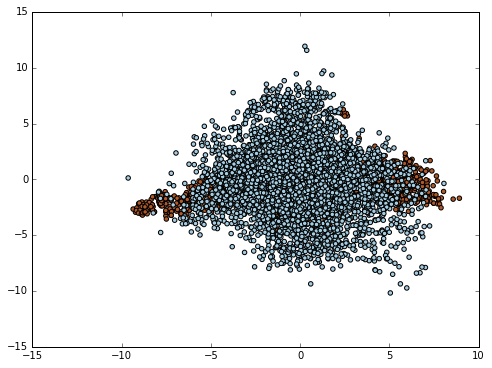

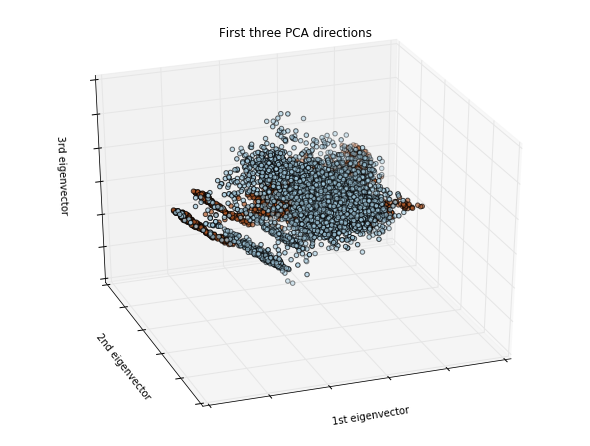

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features.
# Y = iris.target

X = X_train
Y = y_train

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(10, 6))
plt.clf()

X_reduced = PCA(n_components=3).fit_transform(X_train)

# # Plot the training points
# plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
fig = plt.figure(0, figsize=(8, 6))
plt.scatter(X_reduced[:, 1], X_reduced[:, 2], c=Y, cmap=plt.cm.Paired)

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [47]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec
from sklearn import preprocessing
import random
import pickle
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def average_docment(document_embedding):
	return np.average(document_embedding, axis=0)

def sum_docment(document_embedding):
	return np.sum(document_embedding, axis=0)

def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Apply the word2vec model to the data sets --- #

	model_name_en = "./data/model-en/W2Vmodle.bin"
	model_name_jp = "./data/model-jp/W2Vmodle.bin"

	df_pairs_sample = df_pairs.iloc[0:5000]

	df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
	df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


	# Feature 1: TF-IDF + Average word2vec

	# --- Find tf-idf * word2vec features --- #

    #  For English text:
    # texts_en = [doc.split() for doc in list(df_pairs_sample["en_article"])]
	texts_en = [doc.split() for doc in list(df_pairs["en_article"])]
	dictionary_en = corpora.Dictionary(texts_en)
	corpus_en = [dictionary_en.doc2bow(text) for text in texts_en]
	tfidf_en = models.TfidfModel(corpus_en)

	#  For Japanese text:
	# texts_jp = [doc.split() for doc in list(df_pairs_sample["jp_article"])]
	texts_jp = [doc.split() for doc in list(df_pairs["jp_article"])]
	dictionary_jp = corpora.Dictionary(texts_jp)
	corpus_jp = [dictionary_jp.doc2bow(text) for text in texts_jp]
	tfidf_jp = models.TfidfModel(corpus_jp)

	features_en = doc2feature(corpus_en[:5000], tfidf_en, dictionary_en, model_en)
	features_jp = doc2feature(corpus_jp[:5000], tfidf_jp, dictionary_jp, model_jp)

	# --- When do not apply the tfidf re-weighting --- #
	flag_NO_tfidf = False
	if flag_NO_tfidf:

		df_pairs_sample["sum_vector_en"] = df_pairs_sample['word2vec_en'].apply(sum_docment)
		df_pairs_sample["sum_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(sum_docment)
		df_pairs_sample["average_vector_en"] = df_pairs_sample['word2vec_en'].apply(average_docment)
		df_pairs_sample["average_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(average_docment)

		features_en = list(df_pairs_sample["average_vector_en"])
		features_jp = list(df_pairs_sample["average_vector_jp"])


	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle((features_en_wrong))
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong = np.split(X, [2000, 3000, 5000])
	y_train1, y_test, y_train2, y_train3_wrong = np.split(y, [2000, 3000, 5000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

	# --- SVM Training --- #

	clf = svm.SVC(kernel="rbf", gamma=0.001, C=100, probability=True)

	# 在使用
	standerlization = 0
	if standerlization == 1:
		scaler = preprocessing.StandardScaler().fit(X_train)
		X_scaled = scaler.transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)

	if standerlization == 2:
		min_max_scaler = preprocessing.MinMaxScaler()
		X_scaled = min_max_scaler.fit_transform(X_train)
		X_test_scaled = min_max_scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)
	else:
		clf.fit(X_train, y_train)
		# clf.score(X_train, y_train)
		# clf.score(X_test, y_test)
		y_test_predict = clf.predict(X_test)
		y_train_predict = clf.predict(X_train)



	print "classification report of TRAINING data:"
	print(classification_report(y_train, y_train_predict))

	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict))




# 	# --- Prepare for a new independent evaluation balanced data --- #

# 	X[60000:65000].shape

# 	df_pairs_evaluate = df_pairs.iloc[55000:60000]

# 	df_pairs_evaluate['word2vec_en'] = df_pairs_evaluate['en_article'].apply(doc2vec_en)
# 	df_pairs_evaluate['word2vec_jp'] = df_pairs_evaluate['jp_article'].apply(doc2vec_jp)


# 	features_en_eva = doc2feature(corpus_en, tfidf_en, dictionary_en, model_en)
# 	features_jp_eva = doc2feature(corpus_jp, tfidf_jp, dictionary_jp, model_jp)


# 	# --- Evaluation for SVM --- #

# 	y_test_proba = clf.predict_proba(X_test)
# 	y_train_proba = clf.predict_proba(X_train)

# 	# sim_results_train, rank_results_train = find_ranking(projection1_train, projection2_train)
# 	sim_results_test, rank_results_test = find_ranking(X_test[:,:200] ,X_test[:,200:], clf)


# 	print pd.Series(rank_results_test).describe()


Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 3
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      5000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      9000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.94      0.97      1000

avg / total       1.00      0.94      0.97      1000



In [72]:
	# 修改训练数据位4000个True和4000个False
	X_train1, X_test, X_train2, X_train3_wrong, X_o = np.split(X, [2000, 3000, 5000, 9000])
	y_train1, y_test, y_train2, y_train3_wrong, Y_o = np.split(y, [2000, 3000, 9000, 9000])
	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)
	clf.fit(X_train, y_train)
	y_test_predict = clf.predict(X_test)
	y_train_predict = clf.predict(X_train)

	print "classification report of TRAINING data:"
	print(classification_report(y_train, y_train_predict))

	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict))

classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      4000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.95      0.98      1000

avg / total       1.00      0.95      0.98      1000



In [74]:
	df_pairs_evaluate = df_pairs.iloc[55000:60000]

	df_pairs_evaluate['word2vec_en'] = df_pairs_evaluate['en_article'].apply(doc2vec_en)
	df_pairs_evaluate['word2vec_jp'] = df_pairs_evaluate['jp_article'].apply(doc2vec_jp)

	features_en_eva = doc2feature(corpus_en[60000:61000], tfidf_en, dictionary_en, model_en)
	features_jp_eva = doc2feature(corpus_jp[60000:61000], tfidf_jp, dictionary_jp, model_jp)

	features_merge_eva = np.concatenate((features_en_eva,features_jp_eva), axis = 1)

	features_en_wrong_eva =  features_en[:1000]
	# features_en_wrong_eva = np.array(features_en_eva)
	# np.random.shuffle((features_en_wrong_eva))
# 	c = np.all(features_en_wrong_eva == features_en_eva, axis=1)
# 	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong_eva,features_jp_eva), axis = 1)

	X_eva = np.concatenate((features_merge_eva, features_merge_wrong), axis = 0)
	y_eva = np.concatenate((np.ones(len(features_merge_eva)), np.zeros(len(features_en_wrong_eva))), axis = 0)

	y_eva_predict = clf.predict(X_eva)

	print "classification report of TRAINING data:"
	print(classification_report(y_eva, y_eva_predict))

/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
0
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.98      0.92      0.94      1000
        1.0       0.92      0.98      0.95      1000

avg / total       0.95      0.95      0.95      2000



In [73]:
X_train.shape

(8000, 400)